## IMPORTING LIBRARIES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm

# Dataset building

In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Define dataset directory
dataset_path = "./16000_pcm_speeches/audio"  # Change this to your dataset folder path

# Get all subfolders
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Randomly choose one folder as the speaker folder
speaker_folder = "Nelson_Mandela"

# Define output directories
speaker_dir = "speaker"
non_speaker_dir = "non_speaker"

# Create output directories if they don't exist
os.makedirs(speaker_dir, exist_ok=True)
os.makedirs(non_speaker_dir, exist_ok=True)

# Copy and rename files
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    dest_folder = speaker_dir if folder == speaker_folder else non_speaker_dir
    print(f"Copying files from {folder} to {dest_folder}...")
    for file in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):  # Ensure it's a file
            new_filename = f"{folder}_{file}"  # Append folder name
            shutil.copy(file_path, os.path.join(dest_folder, new_filename))

print(f"Speaker files copied from: {speaker_folder}")
print("All other files copied to non_speaker folder with renamed format '<foldername>_<filename>'.")


## FEATURE EXTRACTION

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set the parent directory for speaker folders
parent_dir = "./dataset"

# List of speaker folders
speaker_folders = [
    "speaker",
    "non_speaker",

]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in tqdm(os.listdir(speaker_folder_path)):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

2025-02-19 13:03:55.538546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 13:03:55.699756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739950435.779677   24922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739950435.824587   24922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 13:03:55.996216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Print the first few features
for feature in X[:1]:
    print(feature)

[[-3.3519223   0.71071965  0.19151686 -0.17820357  0.29945368  0.44474334
   0.35982573  0.58450997  0.32516792  0.508709   -0.17174487  0.14186478
   0.13535982]
 [-0.48726568  2.3298376   0.8715698  -0.21357974  0.6018518   0.5908124
  -0.27008572  0.5509829  -0.619417    0.02918458 -1.9414716  -0.36961496
  -1.0728043 ]
 [ 2.4120066   1.241598    0.5802003   0.35867757  0.3707296   0.3013019
  -0.6936464  -0.35401192 -0.72531474 -0.31400824 -1.2557967  -0.57848036
  -1.3432556 ]
 [ 1.4729887   1.3262541   0.81653124  1.2604736   0.60707086  0.5626623
  -0.6999824  -0.47470134 -0.9284792  -0.40080732 -1.1461962  -0.87468284
  -1.5211314 ]
 [-0.35289228  1.3712579   1.2118194   1.7040757   1.0965445   0.46221206
  -0.6141302  -0.25156513 -1.0629911  -0.3410071  -1.2689323  -0.97679096
  -0.9776002 ]
 [-1.5247109   1.4934533   1.2919319   1.3823392   1.1178652   0.45333096
  -0.47052774 -0.04630015 -0.80532473 -0.18437174 -1.097654   -0.8420789
  -0.76795226]
 [-2.1555116   1.4698662  

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## MODEL SET UP - TRAIN/TEST SPLIT and EVALUATION

Splitting the data into 70% train and the remaining will be split equally into validation and test datasets.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (5250, 32, 13)
Validation Data Shape: (1125, 32, 13)


## TRAINING

In the context of setting up neural network layers, the numbers 128 and 64 refer to the number of neurons or units in those particular layers. 

tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])): This is an LSTM (Long Short-Term Memory) layer with 128 units. The LSTM layer is a type of recurrent neural network (RNN) layer that is particularly effective for sequence data.

tf.keras.layers.Dense(64, activation='relu'): This is a dense (fully connected) layer with 64 units and ReLU (Rectified Linear Unit) activation function. Dense layers are used for fully connecting every neuron in one layer to every neuron in the next layer.

tf.keras.layers.Dense(len(speaker_folders), activation='softmax'): This is the output layer with as many units as there are classes (determined by len(speaker_folders)). The softmax activation function is often used in the output layer for multi-class classification problems, as it converts raw scores into probabilities.

These choices (128, 64) are somewhat arbitrary and can be adjusted based on the specific characteristics of your data and the complexity of the problem. The number of units in a layer is a hyperparameter that you can experiment with during model tuning. More complex problems or data may require more units, but this also increases the model's capacity and may lead to overfitting if not balanced.

We are also using early stopping to avoid extra runtime and overfitting on the training dataset. Running for 20 Epochs with adam optimizer for compilation.

I0000 00:00:1739950621.633775   24922 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 4GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/asifkh/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1739950625.871196   25546 cuda_dnn.cc:529] Loaded cuDNN version 90300


165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9170 - loss: 0.1639 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9991 - val_loss: 0.0080
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9974 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0019
Early stopping triggered at epoch 3


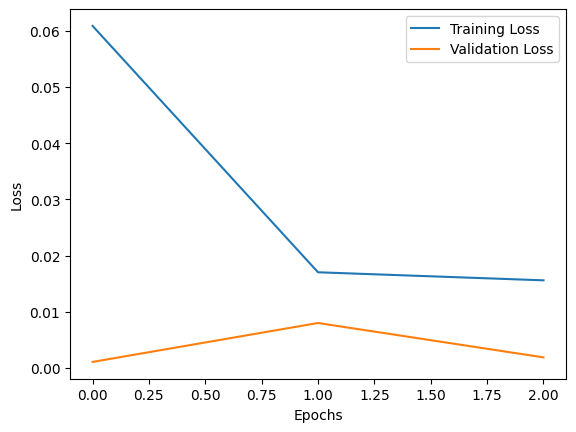

In [6]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## EVALUATION

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test Evaluation Accuracy: 0.9991119005328597
Weighted F1 Score: 0.9991112600924222


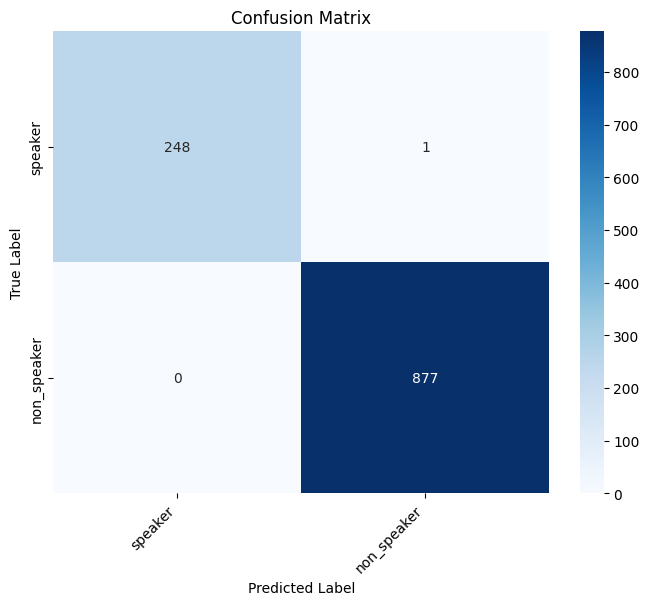

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Pleae upvote if you find this notebook helpful

In [8]:
# Save the model to a file
model.save('speaker_recognition_model.h5')

In [10]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('speaker_recognition_model.h5')

# Define the function to preprocess the audio file and predict the class
def predict_audio_class(audio_file_path, model, label_encoder):
    # Load the audio file
    audio, sr = librosa.load(audio_file_path, sr=None, duration=1)
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Normalize MFCC features
    mfccs = StandardScaler().fit_transform(mfccs)
    
    # Reshape the features to match the input shape of the model
    mfccs = mfccs.T[np.newaxis, ...]
    
    # Predict the class probabilities
    y_pred_probabilities = model.predict(mfccs)
    
    # Get the predicted class index
    y_pred = np.argmax(y_pred_probabilities, axis=1)
    
    # Decode the predicted class index to the original label
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    return y_pred_decoded[0]

# Example usage
audio_file_path = 'dataset/non_speaker/Benjamin_Netanyau_7.wav'
predicted_class = predict_audio_class(audio_file_path, model, label_encoder)
print(f"The predicted class for the audio file is: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
The predicted class for the audio file is: non_speaker
